# Milestone 3 - Regression Simulation 

## Author - Connor Higgins



## Instructions

Using the California dairy production dataset, perform time series analysis on the data for one of Cottage Cheese Production, Milk Production, or Ice Cream Production (your choice) to answer the following questions:

1. Is this time series stationary?
2. Is there a significant seasonal component?
3. For the residual from the STL decomposition of the time series what is the order of the ARMA(p,q) process that best fits?

Then forecast production for 12 months and report both numeric values and plot the confidence intervals.

1. Are the confidence intervals reasonably small compared to the forecast means?
2. How do the confidence intervals behave as time moves to the future?


### Note
Please clearly outline the results with markdown text. Be sure your discussion includes narrative for your figures and tables so it is clear to the reader the importance of each bit of evidence.

#### Preparing Dataset

In [1]:
fileName = "https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/CADairyProduction.csv"

In [2]:
# Loading necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
import statsmodels.formula.api as sm
sns.set()

In [3]:
# Determining start and end months
df = pd.read_csv(fileName)
print(df[['Year', 'Month']].head(1)) # start-month
print(df[['Year', 'Month']].tail(1)) # end-month

   Year Month
0  1995   Jan
     Year Month
227  2013   Dec


In [4]:
# Creating time-series index which matches year and month columns.
df.index = pd.date_range(start = '1-1995', end = '1-2014', freq = 'M')
df.index

DatetimeIndex(['1995-01-31', '1995-02-28', '1995-03-31', '1995-04-30',
               '1995-05-31', '1995-06-30', '1995-07-31', '1995-08-31',
               '1995-09-30', '1995-10-31',
               ...
               '2013-03-31', '2013-04-30', '2013-05-31', '2013-06-30',
               '2013-07-31', '2013-08-31', '2013-09-30', '2013-10-31',
               '2013-11-30', '2013-12-31'],
              dtype='datetime64[ns]', length=228, freq='M')

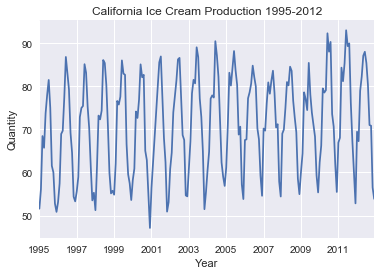

In [5]:
# Plotting time series of Icecream.Prod
df.loc[:'2012-12-31', 'Icecream.Prod'].plot() # dropping the last 12 months for forecasting
plt.title('California Ice Cream Production 1995-2012')
plt.xlabel('Year')
plt.ylabel('Quantity')
plt.show()

A timeseries plot of California Ice Cream Production 1995-2012. At first glance, there appears to be a significant seasonal component, with a significant drop in production during the winter months and a significant rise in production during the summer months. Additionally, there appears to be a slight overall positive trend.

### Part I. Model Creation
#### 1. & 2. Determing if the time series is stationary; determining whether the time series has a significant seasonal component. 

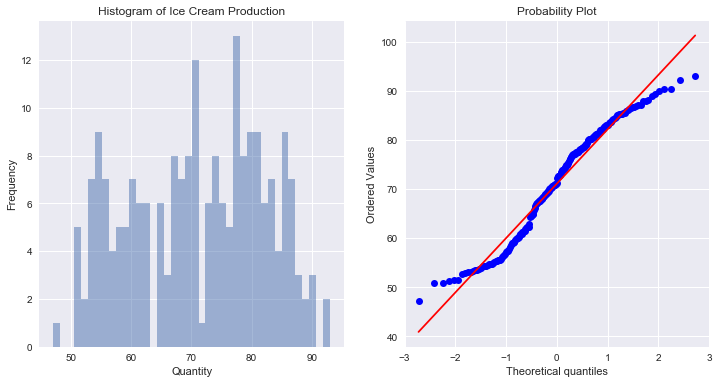

KS-Stat: 1.0
p-value: 0.0


In [6]:
# Plotting Histogram and Probplot of Icecream.Prod
plt.figure(figsize=(12, 6))
df.loc[:'2012-12-31', 'Icecream.Prod'].hist(bins=40, alpha=0.5, ax=plt.subplot(121))
plt.title('Histogram of Ice Cream Production')
plt.ylabel('Frequency')
plt.xlabel('Quantity')
ss.probplot(df.loc[:'2012-12-31', 'Icecream.Prod'], plot=plt.subplot(122))
plt.show()

# Returning KS test statistics
ks_stat, pval = ss.kstest(df.loc[:'2012-12-31', 'Icecream.Prod'], 'norm')
print(f'KS-Stat: {ks_stat}')
print(f'p-value: {pval}')

Based on the KS-stat and associated p-value, as well as the tails of the probability plot, it is highly unlikely that Ice Cream Production in California follows a normal distribution.

C:\python\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


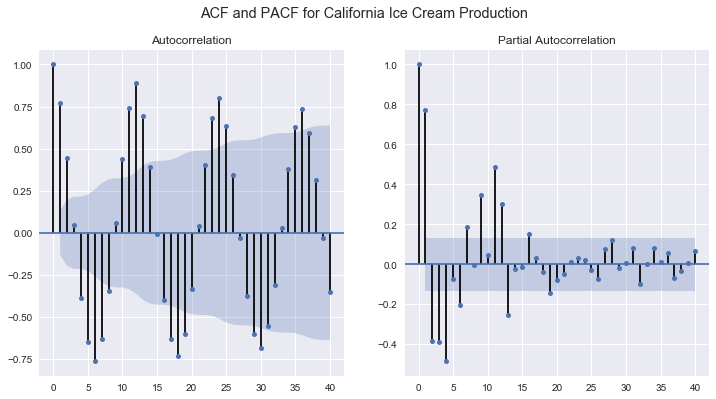

DF-statistic = -2.3427726920520313
p-value = 0.15854363753309264
Number of lags used = 14


In [7]:
# Plotting Autocorrelation and Partial Autocorrelation
import statsmodels.graphics.tsaplots as splt
plt.figure(figsize=(12, 6))
splt.plot_acf(df.loc[:'2012-12-31', 'Icecream.Prod'], lags=40, ax=plt.subplot(121))
splt.plot_pacf(df.loc[:'2012-12-31', 'Icecream.Prod'], lags=40, ax=plt.subplot(122))
plt.suptitle('ACF and PACF for California Ice Cream Production')
plt.show()

# Obtaining Dicky Fuller test statistics fro Icecream.Prod
from statsmodels.tsa.stattools import adfuller
DFstat_IceCream = adfuller(df.loc[:'2012-12-31', 'Icecream.Prod'])
print(f'DF-statistic = {DFstat_IceCream[0]}')
print(f'p-value = {DFstat_IceCream[1]}')
print(f'Number of lags used = {DFstat_IceCream[2]}')

The Autocoorelation (ACF) and Partial Autocorrelation (PACF) for California Ice Cream Production (1995-2013). The AC function has significant values for repeating intervals (20 lags total), with a very slow overall decay; moreover, the PAC function shows signficant values for 12 lags. We can conclude from the latter that Ice Cream Production is not stationary, while we can conclude from the former that it contains a significant seasonal component.

To further test whether the series is stationary, the Dicky Fuller test was also applied. With a p-value noticably above 0.05, we cannot reject the null hypthesis that the time series is not stationary.

#### 3. Determining ARMA best fit for STL decomposition residual.

Icecream.Prod timeseries Decomposed


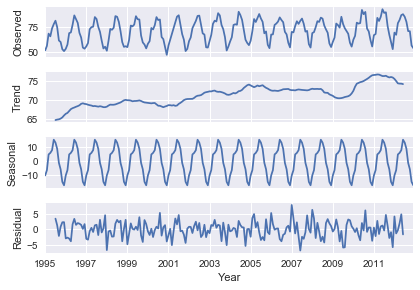

In [8]:
# Decomposing Icecream.Prod timeseries into trend, seasonal, & residual components
import statsmodels.tsa.seasonal as sts
model = sts.seasonal_decompose(df.loc[:'2012-12-31', 'Icecream.Prod'], model='additive')
print('Icecream.Prod timeseries Decomposed')
model.plot()
plt.xlabel('Year')
plt.show()

The Icecream.Prod timeseries decomposed into trend, seasonal, and residual components. Prior to any other tests, it appears as though trend and seasonal components were successfully isolated, with the residual component appearing stationary.

In [9]:
# Creating DataFrame of model trend, seasonal, and residual components
modeldf = pd.DataFrame({'trend' : model.trend,
                        'seasonal' : model.seasonal,
                        'resid' : model.resid},
                        index = df.loc[:'2012-12-31', 'Icecream.Prod'].index)
print('Head(10) and Tail(10) of Model Components DataFrame')
modeldf.head(10).append(modeldf.tail(10)) # printing first and last 10 months of timeseries

Head(10) and Tail(10) of Model Components DataFrame


,resid,seasonal,trend
1995-01-31,NaN,-10.305639,NaN
1995-02-28,NaN,-6.473188,NaN
1995-03-31,NaN,4.804548,NaN
1995-04-30,NaN,5.920168,NaN
1995-05-31,NaN,7.889736,NaN
1995-06-30,NaN,15.402300,NaN
1995-07-31,3.484830,13.325962,64.664208
1995-08-31,1.345671,8.850371,64.784958
1995-09-30,-2.096462,-1.235705,64.862167
1995-10-31,0.860776,-5.885401,65.046625


The first and last 10 rows of the Model components DataFrame. Both trend and residual components are missing data for the first and last 6 rows, meaning that analysis will look at a truncated timeseries: 1995-07-31 to 2012-06-30.

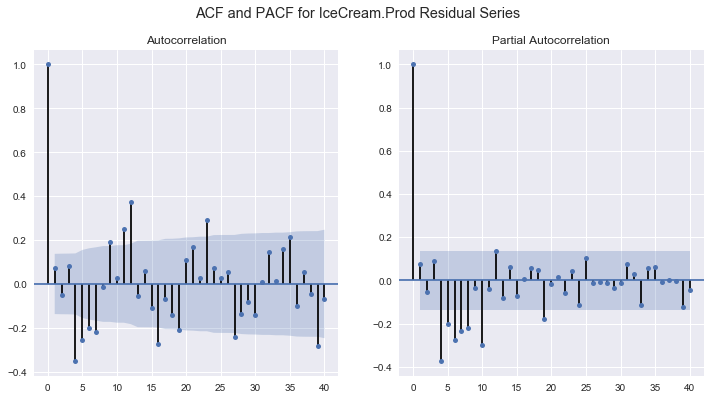

In [10]:
# Plotting Autocorrelation and Partial Autocorrelation for model.resid
plt.figure(figsize=(12, 6))
splt.plot_acf(modeldf['1995-07-31': '2012-06-30'].resid, lags=40, ax=plt.subplot(121))
splt.plot_pacf(modeldf['1995-07-31': '2012-06-30'].resid, lags=40, ax=plt.subplot(122))
plt.suptitle('ACF and PACF for IceCream.Prod Residual Series')
plt.show()

ACF and PACF plots for the Icecream.Prod (model) residual series. Contrary to observations of the IceCreamProd decomposition plots, there are 12 lags for the ACF and 8 lags for the PACF that are significant. This provides evidence that the residual component was not wholly separated from the seasonal component. However, by sepearating the trend and seaonsonal components, the residual series contains far fewer significant lags that the original Icecream.Prod timeseries.

In [11]:
# Obtaining DF statistics for Icecream.Prod residual
residual = modeldf['1995-07-31': '2012-06-30'].resid # renaming residual series
DFstat_resid = adfuller(residual)
print(f'DF statistic = {DFstat_resid[0]}')
print(f'p-value = {DFstat_resid[1]}')
print(f'Number of lags used = {DFstat_resid[2]}')

DF statistic = -10.564206212194348
p-value = 7.590670273286857e-19
Number of lags used = 9


Applying the Dicky Fuller test to the truncated residual timeseries, we receive a highly significant p-value (p < 0.01). This allows us to reject the null hypothesis that the timeseries is not stationary. While the above ACF and PACF plots might suggest some dependency between time series values, the series as a whole appears to be stationary.

In [12]:
# Determining ARMA best fit for STL decomposition residual.
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
best_BIC = 9999999999999999.0
for p in range(5): # testing up to p of order 4
    for q in range(5): # testing up to q of order 4
        if(p > 0 or q > 0):
            try:
                order = (p, 0, q)
                model = ARIMA(residual , order = order)
                model_fit = model.fit(disp=0, method='mle', trend='nc')
                BIC = ARIMAResults.bic(model_fit)
                print(f'Tested model of order {order} and a BIC of {BIC}')
                if(BIC < best_BIC):
                        best_model = model_fit
                        best_BIC = BIC
                        best_order = order
            except: 
                pass
print('----------------------------------------------------------------')
print(f'Best model with BIC {best_BIC} and order {best_order}')

Tested model of order (0, 0, 1) and a BIC of 982.4765914363132
Tested model of order (0, 0, 2) and a BIC of 966.7719069303962
Tested model of order (0, 0, 3) and a BIC of 982.4875598787063
Tested model of order (0, 0, 4) and a BIC of 937.1227921465519
Tested model of order (1, 0, 0) and a BIC of 982.6432797415919
Tested model of order (1, 0, 1) and a BIC of 960.376258161773
Tested model of order (1, 0, 2) and a BIC of 953.5143313532133
Tested model of order (1, 0, 3) and a BIC of 958.6978192853888
Tested model of order (2, 0, 0) and a BIC of 987.3153344138412
Tested model of order (2, 0, 1) and a BIC of 950.5702382519312
Tested model of order (2, 0, 2) and a BIC of 952.478086260501
Tested model of order (2, 0, 3) and a BIC of 956.7053250599929
Tested model of order (3, 0, 0) and a BIC of 990.9908785085537
Tested model of order (3, 0, 1) and a BIC of 948.630714615932
Tested model of order (3, 0, 2) and a BIC of 954.5461574518199


C:\python\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Tested model of order (3, 0, 3) and a BIC of 936.7399773995812
Tested model of order (4, 0, 0) and a BIC of 965.172401347143
Tested model of order (4, 0, 1) and a BIC of 913.7969543006702
Tested model of order (4, 0, 2) and a BIC of 919.058756727617
Tested model of order (4, 0, 3) and a BIC of 922.4910567492468
Tested model of order (4, 0, 4) and a BIC of 924.89012209085
----------------------------------------------------------------
Best model with BIC 913.7969543006702 and order (4, 0, 1)


C:\python\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


For the residual from the STL decomposition of the time series for Ice Cream Production, the best ARMA(p,q) process has an order of (4, 0, 1) with a BIC of 913.797. While an AR(4) series may run the risk of overfitting, the BIC score is markedly better than models with a lower order of p.

In [13]:
print(best_model.summary())

                              ARMA Model Results                              
Dep. Variable:                  resid   No. Observations:                  204
Model:                     ARMA(4, 1)   Log Likelihood                -440.944
Method:                           mle   S.D. of innovations              2.070
Date:                Sat, 07 Jul 2018   AIC                            893.888
Time:                        14:45:26   BIC                            913.797
Sample:                    07-31-1995   HQIC                           901.942
                         - 06-30-2012                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
ar.L1.resid     0.7452      0.063     11.746      0.000       0.621       0.870
ar.L2.resid    -0.1448      0.082     -1.762      0.080      -0.306       0.016
ar.L3.resid     0.1636      0.082      1.994    

### Part II. Forecasting Production
#### Predicting trend and seasonal components

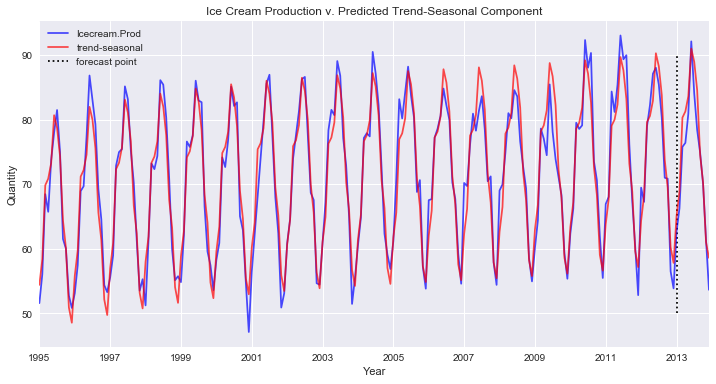

In [14]:
# Normalizing Month Count, NumSqred & NumCubed Features in DataFrame df
df[['Month.Count', 'monthNumSqred', 'monthNumCubed']] = df[['Month.Count', 'monthNumSqred', 'monthNumCubed']].apply(ss.zscore)

# Creating Month dummy variables
dummies = pd.get_dummies(df['Month'])
df[list(dummies.columns)] = dummies
df.head()

# Creating Features and Label matrices
X = df.loc[:'2012-12-31', ['Month.Count', 'monthNumSqred', 'monthNumCubed', 'Jan', 'Feb', 'Mar', 'Apr',
                           'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']].as_matrix()
y = df.loc[:'2012-12-31', 'Icecream.Prod'].as_matrix()

# Creating and Fitting Model
import sklearn.linear_model as lm
lm_mod = lm.LinearRegression(fit_intercept = False)
mod_fit = lm_mod.fit(X, y)

# Creating predictions from features matrix (with 12 additional months forecasted)
Xall = df.loc[:, ['Month.Count', 'monthNumSqred', 'monthNumCubed', 'Jan', 'Feb', 'Mar', 'Apr',
                  'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']].as_matrix()
df.loc[:, 'trend-seasonal'] = mod_fit.predict(Xall)

# Plotting 'trend-seasonal' component against Icecream.Prod
fig = plt.figure(figsize = (12,6))
ax = fig.gca()
df.loc[:, 'Icecream.Prod'].plot(color = 'b', alpha=0.7, ax = ax)
df.loc[:, 'trend-seasonal'].plot(color = 'r', alpha=0.7, ax = ax)
ax.vlines('2013-1-31', 50, 90, linestyles='dotted', label='forecast point')
plt.legend()
plt.title('Ice Cream Production v. Predicted Trend-Seasonal Component')
plt.xlabel('Year')
plt.ylabel('Quantity')
plt.show()

The original IcecreamProd. timeseries (blue) plotted against the trend-seasonal linear model (red). Though some local minima and maxima are not adequately modeled, the overall trend and periodicity appear reasonably captured. However, the differences in local minima and maxima for 2012 and 2013 are of concern, as this error will likely grow over time.

In [15]:
# Calculating RMSE for trend-seasonal model
Predicted = df.loc['2013-01-31':, 'trend-seasonal']
Actual = df.loc['2013-01-31':, 'Icecream.Prod']

RMSE_trendseason = np.sqrt(np.std(Actual - Predicted))

print(f'RMSE: {RMSE_trendseason}')

RMSE: 1.5496556088453068


#### Predicting Residual Component

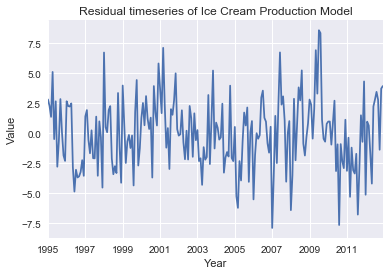

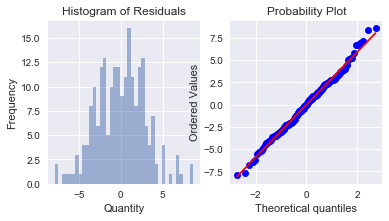

KS-Stat: 0.2707847563024253
P-value: 1.7541523789077473e-14


In [16]:
# Plotting Residual timeseries
df.loc[:'2012-12-31', 'residuals'] = df.loc[:'2012-12-31', 'trend-seasonal'] - df.loc[:'2012-12-31', 'Icecream.Prod']
df.loc[:'2012-12-31', 'residuals'].plot()
plt.title('Residual timeseries of Ice Cream Production Model')
plt.ylabel('Value')
plt.xlabel('Year')
plt.show()

# Plotting Histogram and Probplot of Residual Component
plt.figure(figsize=(6, 3))
df.loc[:'2012-12-31', 'residuals'].hist(bins=40, alpha=0.5, ax=plt.subplot(121))
plt.title('Histogram of Residuals')
plt.ylabel('Frequency')
plt.xlabel('Quantity')
ss.probplot(df.loc[:'2012-12-31', 'residuals'], plot=plt.subplot(122))
plt.show()

# Returning KS test statistics
ks_stat, pval = ss.kstest(df.loc[:'2012-12-31', 'residuals'], 'norm')
print(f'KS-Stat: {ks_stat}')
print(f'P-value: {pval}')

Based on the KS-stat and associated p-value, as well as the contour of both the histogram and probability plot, we can safely reject the null hypothesis that the Residual timeseries of the Ice Cream Production Model does not follow a normal distribution.

In [17]:
# Obtaining DF statistics for trend-seasonal model residual
DFstat_residuals = adfuller(df.loc[:'2012-12-31', 'residuals'])
print(f'DF statistic = {DFstat_residuals[0]}')
print(f'p-value = {DFstat_residuals[1]}')
print(f'Number of lags used = {DFstat_residuals[2]}')

DF statistic = -3.606907715663281
p-value = 0.005630332009884805
Number of lags used = 14


A Dicky Fuller test was conducted for the Residual timeseries. With a p-value considerably smaller than 0.05 (p < 0.01), we can safely reject the null hypthesis that the time series is not stationary.

In [18]:
# Determining best ARMA model fit for trend-seasonal model residual
best_BIC = 9999999999999999.0
for p in range(5): # testing up to p of order 4
    for q in range(5): # testing up to q of order 4
        if(p > 0 or q > 0):
            try:
                order = (p, 0, q)
                model = ARIMA(df.loc[:'2012-12-31', 'residuals'] , order = order)
                model_fit = model.fit(disp=0, method='mle', trend='nc')
                BIC = ARIMAResults.bic(model_fit)
                print(f'Testing model of order {order} and a BIC of {BIC}')
                if(BIC < best_BIC):
                        best_model = model_fit
                        best_BIC = BIC
                        best_order = order
            except: 
                pass
print('----------------------------------------------------------------')
print(f'Best model with BIC {best_BIC} and order {best_order}')

Testing model of order (0, 0, 1) and a BIC of 1075.706685949634
Testing model of order (0, 0, 2) and a BIC of 1080.6342500295857
Testing model of order (0, 0, 3) and a BIC of 1059.4577197020312
Testing model of order (0, 0, 4) and a BIC of 1064.490352967078
Testing model of order (1, 0, 0) and a BIC of 1073.6980510779076
Testing model of order (1, 0, 1) and a BIC of 1073.6518119213747
Testing model of order (1, 0, 2) and a BIC of 1078.3118349755641
Testing model of order (1, 0, 3) and a BIC of 1064.3453202359137
Testing model of order (2, 0, 0) and a BIC of 1076.1581169400108
Testing model of order (2, 0, 1) and a BIC of 1078.7973998365924
Testing model of order (2, 0, 2) and a BIC of 1074.5756044148716
Testing model of order (2, 0, 3) and a BIC of 1069.274281744944
Testing model of order (3, 0, 0) and a BIC of 1070.0465622725662
Testing model of order (3, 0, 1) and a BIC of 1064.6822074358251
Testing model of order (3, 0, 2) and a BIC of 1070.0416769992153
Testing model of order (3, 0

C:\python\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\python\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


For the residual of the trend-seasonal model for Ice Cream Production, the best ARMA(p,q) process has an order of (0, 0, 3) with a BIC of 1059.458. With a p of order 0 and a q of order 3, the model is relatively simple.

In [19]:
print(best_model.summary())

                              ARMA Model Results                              
Dep. Variable:              residuals   No. Observations:                  216
Model:                     ARMA(0, 3)   Log Likelihood                -518.978
Method:                           mle   S.D. of innovations              2.671
Date:                Sat, 07 Jul 2018   AIC                           1045.957
Time:                        14:45:30   BIC                           1059.458
Sample:                    01-31-1995   HQIC                          1051.411
                         - 12-31-2012                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
ma.L1.residuals     0.2752      0.065      4.221      0.000       0.147       0.403
ma.L2.residuals     0.0837      0.068      1.238      0.217      -0.049       0.216
ma.L3.residuals     0.3600      

The MA coefficients for the ARMA(0,3) process are 0.2752 (L1), 0.0837 (L2), and 0.3600 (L3). While L1 and L3 coefficients both have highly significant p-values (p < 0.001), the L2 coefficient has an insignificant p-value (p > 0.05). It appears, however, to play a consequential role in the model.

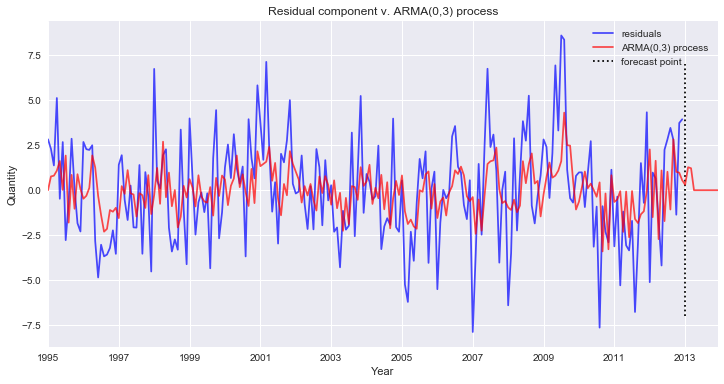

ARMA(0, 3) 12 month forecast
2013-01-31    0.307218
2013-02-28    1.278370
2013-03-31    1.221667
2013-04-30    0.000000
2013-05-31    0.000000
2013-06-30    0.000000
2013-07-31    0.000000
2013-08-31    0.000000
2013-09-30    0.000000
2013-10-31    0.000000
2013-11-30    0.000000
2013-12-31    0.000000
Freq: M, dtype: float64


In [20]:
# Modelling ARMA(0,3), and forecasting 12 months (2013)
model_prediction = best_model.predict(start='1995-01-31', end = '2013-12-31')

# Plotting residual component against ARMA(0,3) process
fig = plt.figure(figsize = (12,6))
ax = fig.gca()
df.loc[:'2012-12-31', 'residuals'].plot(color = 'b', alpha=0.7, ax = ax)
model_prediction.plot(color = 'r', label='ARMA(0,3) process', alpha=0.7, ax = ax)
ax.vlines('2013-1-31', -7, 7, linestyles='dotted', label='forecast point')
plt.xlim(['1995-01-31', '2013-12-31'])
plt.legend()
plt.title('Residual component v. ARMA(0,3) process')
plt.xlabel('Year')
plt.ylabel('Quantity')
plt.show()

# Printing forecast
print('ARMA(0, 3) 12 month forecast')
print(model_prediction.tail(12))

The residual component of the model plotted against an ARMA(0,3) process, alongside the 12 month forecast series. The process quickly converges to the time series mean.

#### Plotting Confidence Interval

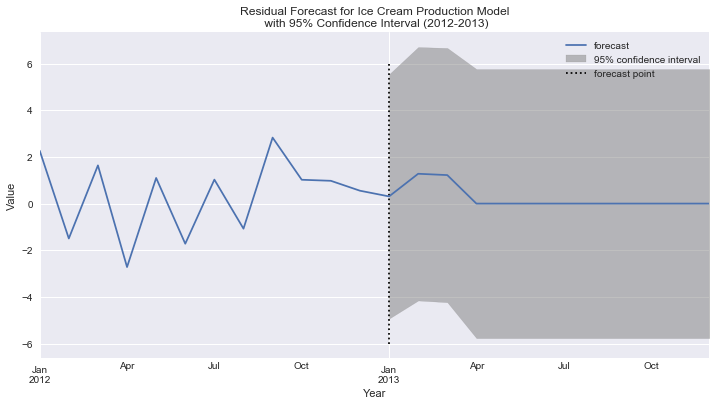

In [21]:
# Plotting confidence intervals for Residual forecast
fig = plt.figure(figsize = (12,6))
ax = fig.gca()
plot = best_model.plot_predict('2012-01-31', '2013-12-31', plot_insample=False, ax=ax)
plt.title('Residual Forecast for Ice Cream Production Model\n with 95% Confidence Interval (2012-2013)')
ax.vlines('2013-1-31', -6, 6, linestyles='dotted', label='forecast point')
plt.xlabel('Year')
plt.legend()
plt.ylabel('Value')
plt.show()

The Residual forecast for the Ice Cream Production model, plotted from Januaray 2012, to the start of forecast (January 2013), to the end of the 12 month forecast (December 2013).

##### 1. Are the confidence intervals reasonably small compared to the forecast means?
The confidence intervals are considerably large when comparing it to the forecast mean of the residual. However, when compared to the forecast mean of the model as a whole (~75-80), this interval is reasonably small. 


##### 2. How do the confidence intervals behave as time moves to the future?
Though somewhat hard to discern, the confidence intervals grow as one moves right from the forecast starting point. For the first 4 months, the interval grows slightly as time progresses. With a more accurate model, this effect would be more apparent.

#### Creating Final Model

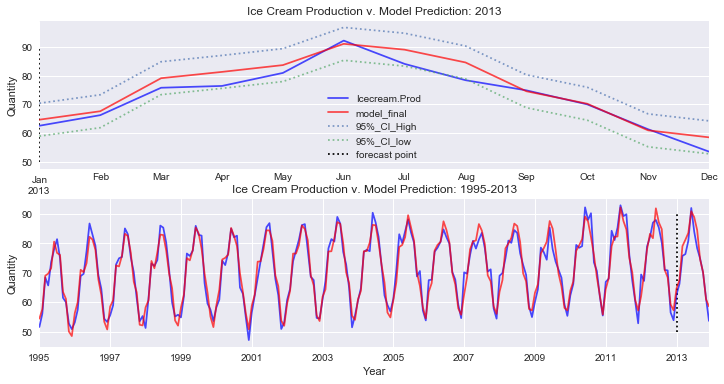

In [22]:
# Predicting across entire timeseries, including the 12 initially dropped months of 2013
X = df.loc[:, ['Month.Count', 'monthNumSqred', 'monthNumCubed',
               'Jan', 'Feb', 'Mar',
               'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep',
               'Oct', 'Nov', 'Dec']].as_matrix()
df.loc[:, 'model_final'] =  mod_fit.predict(X) - model_prediction

# Plotting model_final against Icecream.Prod, both for 2013 alone and 1995-2013
plt.figure(figsize = (12,6))

ax = plt.subplot(211)
df.loc['2013-01-31':, 'Icecream.Prod'].plot(color = 'b', alpha=0.7)
df.loc['2013-01-31':, 'model_final'].plot(color = 'r', alpha=0.7)
(df.loc['2013-01-31':, 'model_final'] + 5.7).plot(alpha=0.7, style=':', label="95%_CI_High") # Obtained from plot_predict method
(df.loc['2013-01-31':, 'model_final'] - 5.7).plot(alpha=0.7, style=':', label="95%_CI_low")
ax.vlines('2013-1-31', 50, 90, linestyles='dotted', label='forecast point')
plt.legend()
plt.title('Ice Cream Production v. Model Prediction: 2013')
plt.xlabel('Year')
plt.ylabel('Quantity')

ax = plt.subplot(212)
df.loc[:, 'Icecream.Prod'].plot(color = 'b', alpha=0.7)
df.loc[:, 'model_final'].plot(color = 'r', alpha=0.7)
plt.title('Ice Cream Production v. Model Prediction: 1995-2013')
ax.vlines('2013-1-31', 50, 90, linestyles='dotted', label='forecast point')
plt.xlabel('Year')
plt.ylabel('Quantity')
plt.show()

Ice Cream Production (Actual) plotted against the model forecast (Predicted) for solely 2013 and for the interval 1995-2013, with confidence intervals from the residual component plotted for the former. Apart from a debatable section from July to August, the timeseries of Ice Cream Production fits well within the CIs of the residual component.

In [23]:
# Calculating RMSE for updated model
Predicted = df.loc['2013-01-31':, 'model_final']
Actual = df.loc['2013-01-31':, 'Icecream.Prod']

RMSE_updated = np.sqrt(np.std(Actual - Predicted))

print(f'RMSE for updated model: {RMSE_updated}') 
print(f'RMSE for original model: {RMSE_trendseason}')

RMSE for updated model: 1.5386353171346767
RMSE for original model: 1.5496556088453068


Finally, the RMSE score for both the updated (trend-seasonal linear model + residual ARMA(3,0) process) and original (trend-seasonal linear model) model. The accuracy of our model has increased modestly with the addition of the residual component. Further work would consist of better modeling of the trend-seasonal component, using the statsmodel package rather than the sklearn package for linear regression.